(compose_own_plot)=
# Create your own figure with `PlotCollection`

:::{warning} work in progress
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm

plt.rcParams["figure.figsize"] = [8, 5]
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# generate data ------------------------------------------------------------------------
n_groups = 4
group_size = [2, 4, 6, 8]

# Group-specific parameters
slopes = rng.normal(1, 0.2, size=n_groups)
intercepts = rng.normal(0, 1, size=n_groups)

# Generate data
data = []
for i in range(n_groups):
    n = group_size[i]
    x_vals = np.sort(rng.uniform(0, 20, size=n))
    noise = rng.normal(0, 1, size=n)
    y_vals = slopes[i] * x_vals + intercepts[i] + noise
    group_labels = np.full(n, i)
    data.append(pd.DataFrame({"x": x_vals, "y": y_vals, "group": group_labels}))

# Combine all groups into a single DataFrame
df = pd.concat(data, ignore_index=True)
df["group"] = df["group"].astype("category")

# Build a PyMC model -------------------------------------------------------------------
prior_mean = 0
prior_std = 1

x_data = df.x.values
y_data = df.y.values

coords = {"groups": df["group"].cat.categories, "obs_ind": df.index}

with pm.Model(coords=coords) as _m:
    x = pm.Data("x", x_data, dims="obs_ind")
    y = pm.Data("y", y_data, dims="obs_ind")
    group = pm.Data("group", df["group"].cat.codes.values, dims="obs_ind")
    # priors
    intercept = pm.Normal("intercept", mu=0, sigma=10, dims=["groups"])
    beta = pm.Normal("beta", mu=prior_mean, sigma=prior_std, dims=["groups"])
    sigma = pm.HalfNormal("sigma", sigma=5)
    # likelihood
    mu = pm.Deterministic("mu", intercept[group] + beta[group] * x, dims="obs_ind")
    pm.Normal("obs", mu=mu, sigma=sigma, observed=y, dims="obs_ind")
    # sample
    idata = pm.sample()

# Generate a grid of points to evaluate on ---------------------------------------------
n_interp_points = 20
xi = np.concatenate(
    [
        np.linspace(group[1].x.min(), group[1].x.max(), n_interp_points)
        for group in df.groupby("group")
    ]
)
g = np.concatenate([[i] * n_interp_points for i in range(n_groups)]).astype(int)
predict_at = {"x": xi, "group": g, "y": np.zeros_like(xi)}

# Posterior prediction on the grid of points -------------------------------------------
coords = {"groups": predict_at["group"], "obs_ind": np.arange(len(xi))}

with _m:
    pm.set_data(predict_at, coords=coords)
    idata.extend(
        pm.sample_posterior_predictive(
            idata,
            var_names=["mu", "y"],
            random_seed=rng,
            progressbar=False,
            predictions=True,
        )
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
/tmp/ipykernel_58937/1987192661.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group in df.groupby("group")
Sampling: []


In [2]:
from xarray_einstats.einops import rearrange

In [3]:
x_pred_da = rearrange(idata.predictions_constant_data["x"], "(group pred_id)=obs_ind -> group pred_id", group=4).assign_coords(group=[0, 1, 2, 3])
x_pred_da

<xarray.DataArray 'x' (group: 4, pred_id: 20)> Size: 640B
array([[ 2.56227265,  2.90150666,  3.24074066,  3.57997467,  3.91920868,
         4.25844268,  4.59767669,  4.93691069,  5.2761447 ,  5.6153787 ,
         5.95461271,  6.29384671,  6.63308072,  6.97231472,  7.31154873,
         7.65078274,  7.99001674,  8.32925075,  8.66848475,  9.00771876],
       [ 4.54477444,  5.17164064,  5.79850684,  6.42537304,  7.05223924,
         7.67910544,  8.30597165,  8.93283785,  9.55970405, 10.18657025,
        10.81343645, 11.44030265, 12.06716885, 12.69403506, 13.32090126,
        13.94776746, 14.57463366, 15.20149986, 15.82836606, 16.45523227],
       [ 3.89277416,  4.7096787 ,  5.52658324,  6.34348779,  7.16039233,
         7.97729688,  8.79420142,  9.61110596, 10.42801051, 11.24491505,
        12.06181959, 12.87872414, 13.69562868, 14.51253323, 15.32943777,
        16.14634231, 16.96324686, 17.7801514 , 18.59705594, 19.41396049],
       [ 2.59843011,  3.16673799,  3.73504587,  4.30335376,  4.87166164,
         5.43996952,  6.00827741,  6.57658529,  7.14489317,  7.71320106,
         8.28150894,  8.84981683,  9.41812471,  9.98643259, 10.55474048,
        11.12304836, 11.69135624, 12.25966413, 12.82797201, 13.39627989]])
Coordinates:
  * group    (group) int64 32B 0 1 2 3
Dimensions without coordinates: pred_id

In [4]:
predictions = rearrange(idata.predictions, "(group pred_id)=obs_ind -> group pred_id", group=4).assign_coords(group=[0, 1, 2, 3])
predictions

<xarray.Dataset> Size: 5MB
Dimensions:  (chain: 4, draw: 1000, group: 4, pred_id: 20)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * group    (group) int64 32B 0 1 2 3
Dimensions without coordinates: pred_id
Data variables:
    mu       (chain, draw, group, pred_id) float64 3MB 2.27 2.554 ... 16.06
    y        (chain, draw, group, pred_id) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0

In [5]:
import arviz_stats as azs
import arviz_plots as azp
import arviz_base as azb
import xarray as xr

## Option 1: quick exploration

In [6]:
data = xr.merge((idata.constant_data, idata.observed_data)).set_coords("group").set_xindex("group")

In [7]:
data

<xarray.Dataset> Size: 560B
Dimensions:  (obs_ind: 20)
Coordinates:
  * obs_ind  (obs_ind) int64 160B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * group    (obs_ind) int32 80B 0 0 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 3 3
Data variables:
    x        (obs_ind) float64 160B 2.562 9.008 4.545 8.868 ... 9.391 9.514 13.4
    obs      (obs_ind) float64 160B 1.647 8.383 2.666 ... 11.06 11.86 15.82
Attributes:
    created_at:                 2025-05-10T01:11:35.482733+00:00
    arviz_version:              0.22.0dev
    inference_library:          pymc
    inference_library_version:  5.22.0

In [8]:
def line_ribbon_dots(da, target, backend, x_pred, x, y, **kwargs):
    hdi = da.azstats.hdi()
    target.fill_between(x_pred, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), **kwargs)
    target.plot(x_pred, da.mean(dim=["chain", "draw"]), **kwargs)
    target.scatter(x, y, **kwargs)

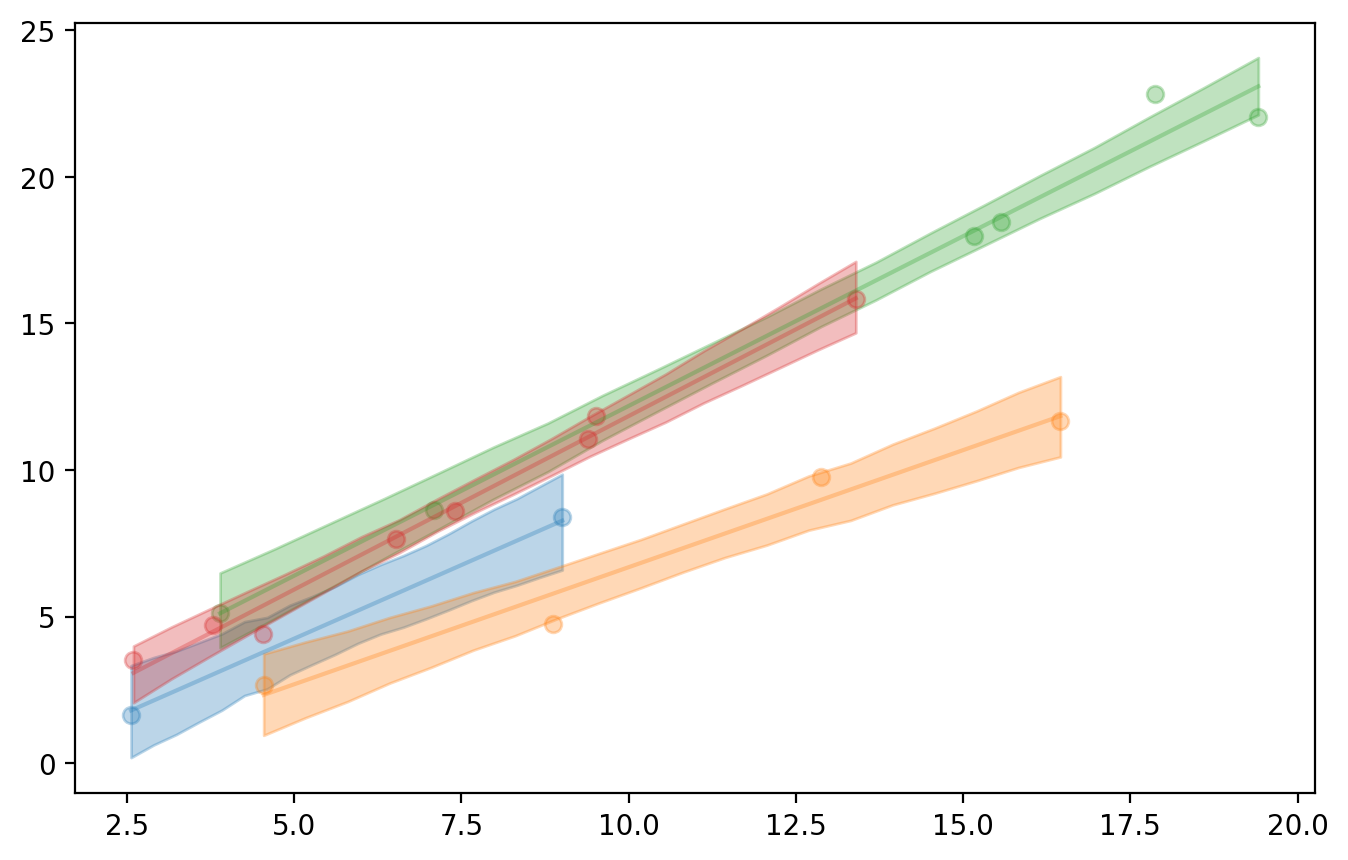

In [9]:
pc = azp.PlotCollection.grid(
    predictions[["mu"]],
    aes={"color": ["group"]},
)
pc.map(line_ribbon_dots, x_pred=x_pred_da, x=data["x"], y=data["obs"], alpha=0.3)

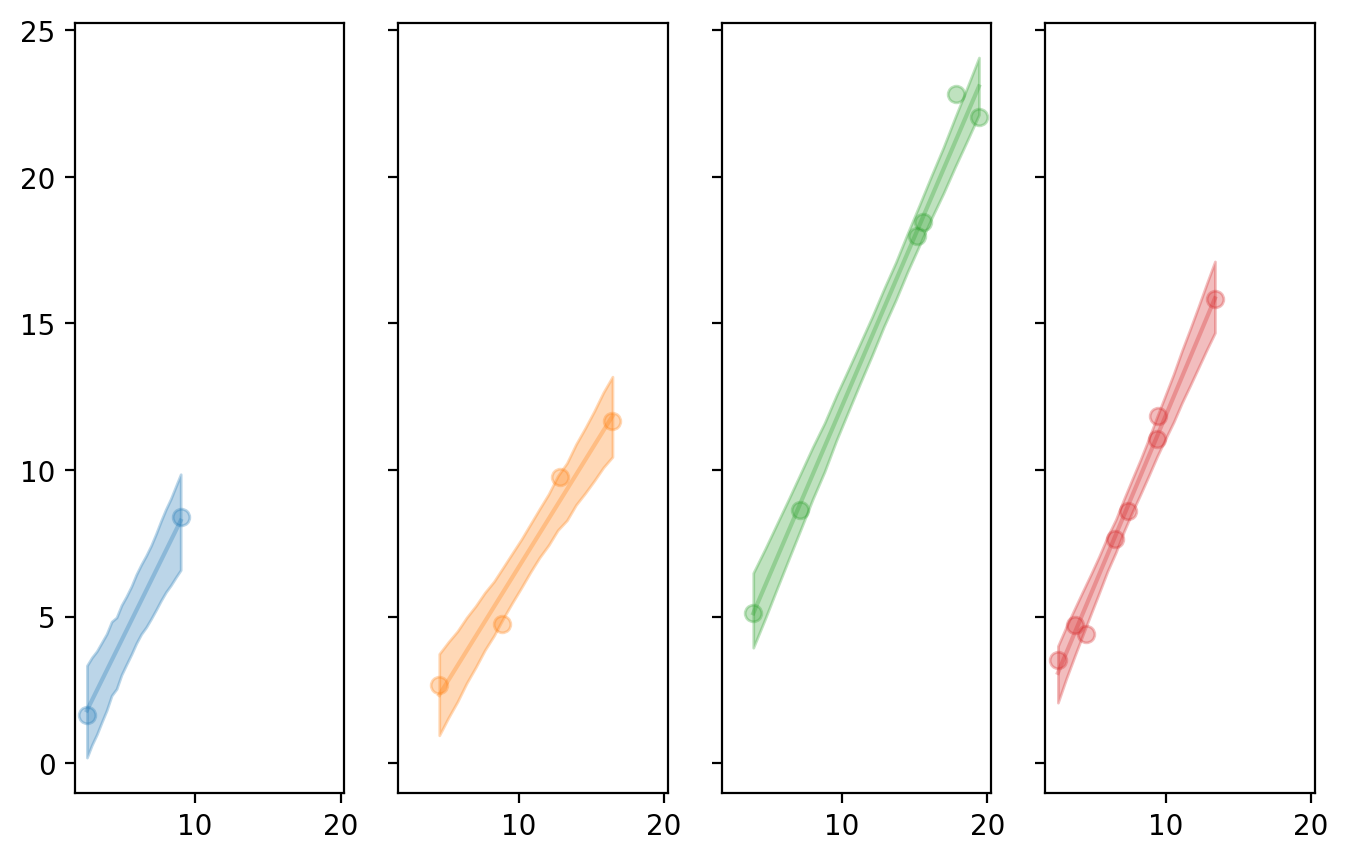

In [10]:
pc = azp.PlotCollection.grid(
    predictions[["mu"]],
    cols=["group"],
    aes={"color": ["group"]},
    plot_grid_kws={"sharex": True, "sharey": True}
)
pc.map(line_ribbon_dots, x_pred=x_pred_da, x=data["x"], y=data["obs"], alpha=0.3)

## Option 2: artist specific functions

In [11]:
def hdi_band(da, target, backend, x, **kwargs):
    return target.fill_between(x, da.sel(hdi="lower"), da.sel(hdi="higher"), **kwargs)

def line(da, target, backend, x, **kwargs):
    return target.plot(x, da, **kwargs)

def scatter(da, target, backend, x, **kwargs):
    return target.scatter(x, da, **kwargs)

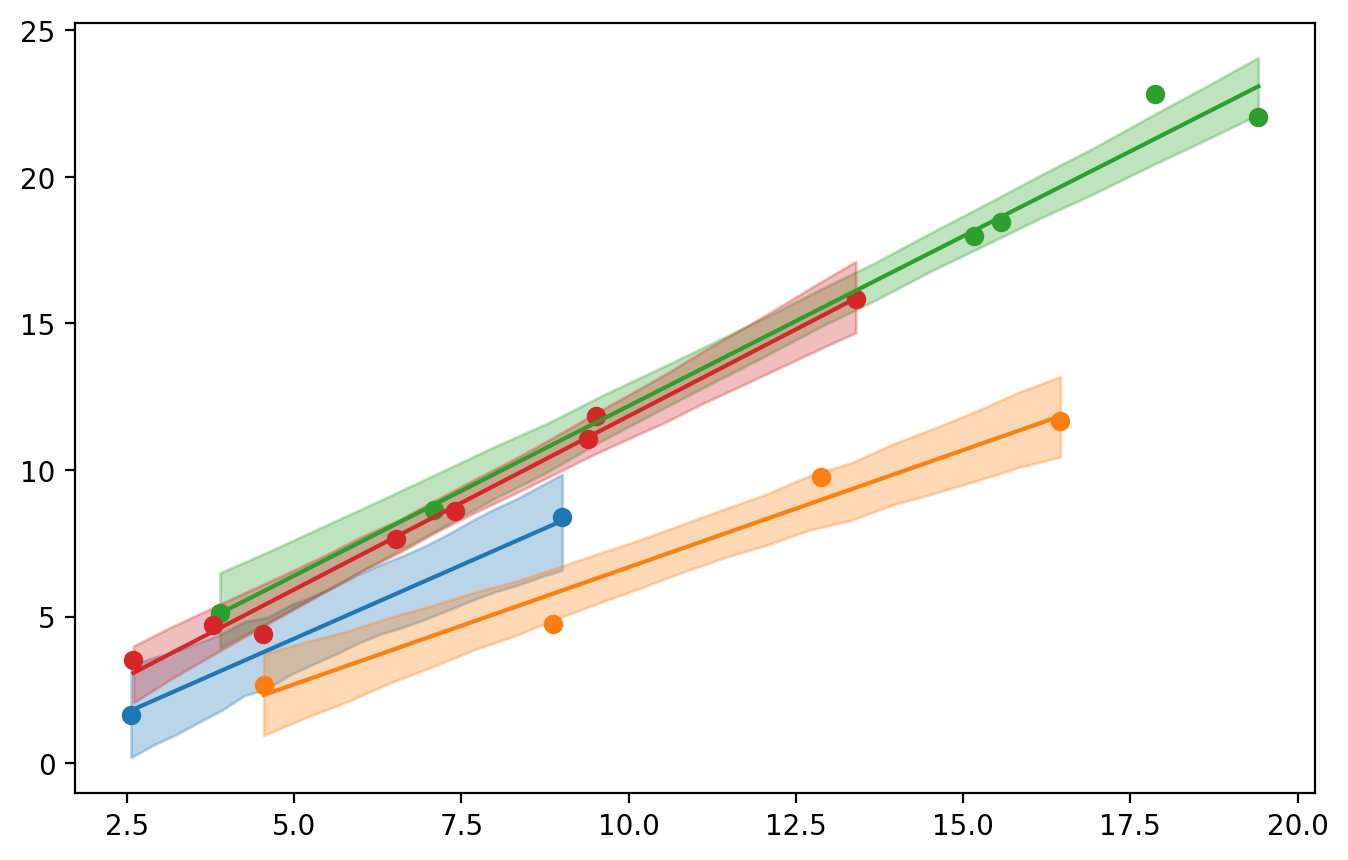

In [12]:
ds = predictions[["mu"]]
pc = azp.PlotCollection.grid(
    ds,
    aes={"color": ["group"]},
)
pc.map(hdi_band, data=ds.azstats.hdi(), x=x_pred_da, alpha=0.3)
pc.map(line, data=ds.mean(["chain", "draw"]), x=x_pred_da)
pc.map(scatter, data=data[["obs"]], x=data["x"])

In [13]:
pc.aes

<xarray.DataTree>
Group: /
└── Group: /color
        Dimensions:  (group: 4)
        Coordinates:
          * group    (group) int64 32B 0 1 2 3
        Data variables:
            mapping  (group) <U7 112B '#1f77b4' '#ff7f0e' '#2ca02c' '#d62728'

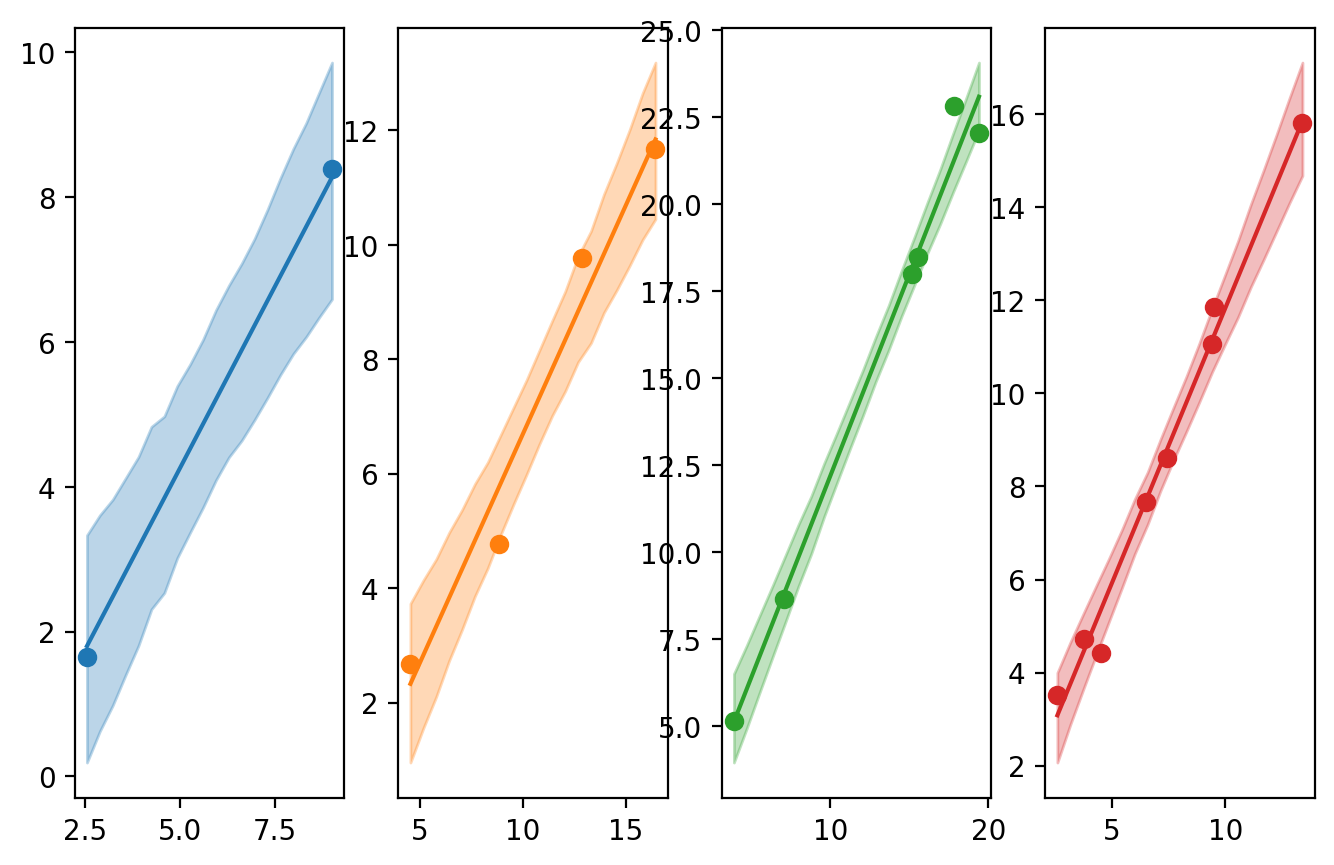

In [14]:
ds = predictions[["mu"]]
pc = azp.PlotCollection.grid(
    ds,
    cols=["group"],
    aes={"color": ["group"]},
)
pc.map(hdi_band, data=ds.azstats.hdi(), x=x_pred_da, alpha=0.3)
pc.map(line, data=ds.mean(["chain", "draw"]), x=x_pred_da)
pc.map(scatter, data=data[["obs"]], x=data["x"])

As of now, the scatter uses the facetting information but not the `aes` one. This is because facetting on dims only is global to any variable,
but aesthetics on dims only are still variable specific because some get the mapping while others get the neutral element.

In [16]:
pc.aes

<xarray.DataTree>
Group: /
└── Group: /color
        Dimensions:  (group: 4)
        Coordinates:
          * group    (group) int64 32B 0 1 2 3
        Data variables:
            mapping  (group) <U7 112B '#1f77b4' '#ff7f0e' '#2ca02c' '#d62728'